In [1]:
import os
import re
import sys
import gzip
import json
import codecs
import pyBigWig
import numpy as np
from pyfaidx import Fasta
from scipy.stats import spearmanr, pearsonr, gaussian_kde
from matplotlib import pyplot as plt
from scipy.stats import percentileofscore
%matplotlib inline

In [2]:
flankToCbf1Ddg = {}
flankToPho4Ddg = {}
firstLine = True
with open("data/experimental/all_predicted_ddGs.csv") as inp:
    for line in inp:
        if firstLine:
            firstLine = False
            continue
        flank, Cbf1_ddg, Pho4_ddg = line.strip().split(',')
        flankToCbf1Ddg[flank] = float(Cbf1_ddg)
        flankToPho4Ddg[flank] = float(Pho4_ddg)

In [3]:
tfToDeltaCountsDict = {}
tfToDeltaCountsDict["cbf1_chipexo"] = json.loads(codecs.open("data/preds/chipexo.cbf1.flankToDeltaLogCount.json", 'r', encoding='utf-8').read())
tfToDeltaCountsDict["cbf1_pbexo"] = json.loads(codecs.open("data/preds/pbexo.cbf1.flankToDeltaLogCount.json", 'r', encoding='utf-8').read())
tfToDeltaCountsDict["pho4_pbexo"] = json.loads(codecs.open("data/preds/pbexo.pho4.flankToDeltaLogCount.json", 'r', encoding='utf-8').read())

In [4]:
tfToBigWigs = {}
tfToBigWigs["cbf1_chipexo"] = (pyBigWig.open("data/cbf1_chipexo/basename_prefix.pooled.positive.bigwig"),
                           pyBigWig.open("data/cbf1_chipexo/basename_prefix.pooled.negative.bigwig"))
tfToBigWigs["cbf1_pbexo"] = (pyBigWig.open("data/cbf1_pbexo/basename_prefix.pooled.positive.bigwig"),
                       pyBigWig.open("data/cbf1_pbexo/basename_prefix.pooled.negative.bigwig"))
tfToBigWigs["pho4_pbexo"] = (pyBigWig.open("data/pho4_pbexo/basename_prefix.pooled.positive.bigwig"),
                       pyBigWig.open("data/pho4_pbexo/basename_prefix.pooled.negative.bigwig"))

In [5]:
chrms = ["chrI","chrII","chrIII","chrIV","chrV","chrVI","chrVII","chrVIII",
         "chrIX","chrX","chrXI","chrXII","chrXIII","chrXIV","chrXV","chrXVI","chrM"]

In [6]:
fastapath = "data/genome/sacCer3.genome.fa"
GenomeDict={}
sequence=''
inputdatafile = open(fastapath)
for line in inputdatafile:
    if line[0]=='>':
        if sequence != '':
            GenomeDict[chrm] = ''.join(sequence)
        chrm = line.strip().split('>')[1]
        sequence=[]
        Keep=False
        continue
    else:
        sequence.append(line.strip())
GenomeDict[chrm] = ''.join(sequence)

In [7]:
motif = "CACGTG"
motifLen = len(motif)
flankLen = 5
gcFlanks = []
flankToCoord = {}
for chrm in chrms:
    sequence = GenomeDict[chrm].upper()
    for m in re.finditer(motif, sequence):
        flank = GenomeDict[chrm][m.start()-flankLen:m.start()]+ \
                GenomeDict[chrm][m.start()+motifLen:m.start()+motifLen+flankLen]
        gcFlanks.append(flank)
        if flank not in flankToCoord:
            flankToCoord[flank] = []
        flankToCoord[flank].append((chrm, m.start()+(motifLen/2)))

In [8]:
len(gcFlanks), len(set(gcFlanks))

(953, 928)

In [9]:
xvals_pho4 = []
xvals_cbf1 = []
for flank in flankToCoord.keys():
    xvals_pho4.append(flankToPho4Ddg[flank])
    xvals_cbf1.append(flankToCbf1Ddg[flank])

In [10]:
for flank in flankToCoord.keys():
    if len(flankToCoord[flank]) > 1:
        print("flank: ", flank)
        print("frequency in genome: ", len(flankToCoord[flank]))
        print("Pho4 BETseq DDG: ", flankToPho4Ddg[flank])
        print("Cbf1 BETseq DDG: ", flankToCbf1Ddg[flank])
        print("Pho4 percentile among genome flanks: ", percentileofscore(xvals_pho4,flankToPho4Ddg[flank]))
        print("Pho4 percentile overall: ", percentileofscore(list(flankToPho4Ddg.values()),flankToPho4Ddg[flank]))
        print("Cbf1 percentile among genome flanks: ", percentileofscore(xvals_cbf1,flankToCbf1Ddg[flank]))
        print("Cbf1 percentile overall: ", percentileofscore(list(flankToCbf1Ddg.values()),flankToCbf1Ddg[flank]))

flank:  ATTCGACTTG
frequency in genome:  2
Pho4 BETseq DDG:  0.052745855133431496
Cbf1 BETseq DDG:  -0.22349197436052393
Pho4 percentile among genome flanks:  53.01724137931034
Pho4 percentile overall:  65.38763046264648
Cbf1 percentile among genome flanks:  12.068965517241379
Cbf1 percentile overall:  8.18023681640625
flank:  GTTCAGGTTT
frequency in genome:  2
Pho4 BETseq DDG:  -0.05544519173036283
Cbf1 BETseq DDG:  0.1454426867894547
Pho4 percentile among genome flanks:  24.78448275862069
Pho4 percentile overall:  36.19384765625
Cbf1 percentile among genome flanks:  84.375
Cbf1 percentile overall:  89.71691131591797
flank:  GAATGTCGCT
frequency in genome:  6
Pho4 BETseq DDG:  -0.03372442098389333
Cbf1 BETseq DDG:  0.03888313453716208
Pho4 percentile among genome flanks:  28.663793103448278
Pho4 percentile overall:  42.51203536987305
Cbf1 percentile among genome flanks:  53.98706896551724
Cbf1 percentile overall:  53.44696044921875
flank:  CACCGATAAT
frequency in genome:  2
Pho4 BETse

cbf1_chipexo


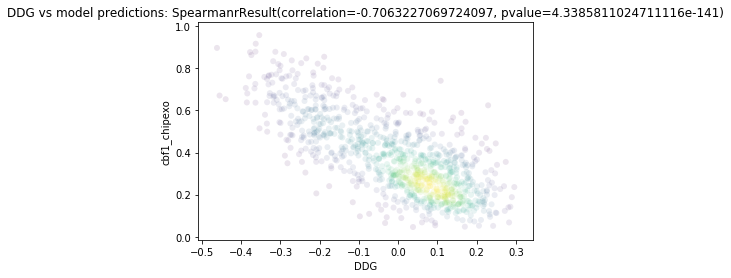

cbf1_pbexo


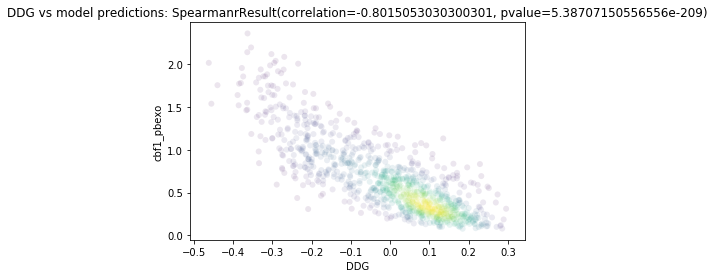

pho4_pbexo


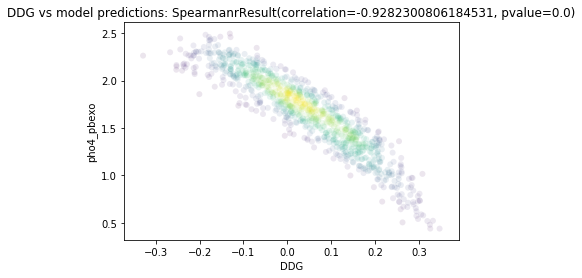

In [11]:
for key in tfToDeltaCountsDict.keys():
    print(key)
    yvals = []
    for flank in flankToCoord.keys():
        y_0 = np.array(tfToDeltaCountsDict[key][flank][0]).astype(float)
        y_1 = np.array(tfToDeltaCountsDict[key][flank][1]).astype(float)
        yvals.append(np.mean(y_1-y_0))
    if "pho4" in key:
        xvals = xvals_pho4
    elif "cbf1" in key:
        xvals = xvals_cbf1
    xy = np.vstack([xvals,yvals])
    z = gaussian_kde(xy)(xy)
    smallFont = {'size' : 10}
    plt.rc('font', **smallFont)
    fig, ax = plt.subplots()
    ax.scatter(xvals, yvals, c=z, edgecolor='', alpha=0.1)
    plt.xlabel("DDG")
    plt.ylabel(key)
    plt.title("DDG vs model predictions: "+str(spearmanr(xvals, yvals)))
    plt.show()

In [12]:
seq_len = 546
posFootprint = {}
negFootprint = {}
for key in tfToBigWigs.keys():
    posFootprint[key] = {}
    negFootprint[key] = {}
    for flank in flankToCoord.keys():
        currentPosCounts= []
        currentNegCounts = []
        for chrm, center in flankToCoord[flank]: 
            start = int(center-(seq_len/2))
            end = int(center+(seq_len/2))
            posvals = np.array(tfToBigWigs[key][0].values(chrm, start, end))
            where_are_NaNs = np.isnan(posvals)
            posvals[where_are_NaNs] = 0.0
            currentPosCounts.append(posvals)
            negvals = np.array(tfToBigWigs[key][1].values(chrm, start, end))
            where_are_NaNs = np.isnan(negvals)
            negvals[where_are_NaNs] = 0.0
            currentNegCounts.append(negvals)
        posFootprint[key][flank] = np.mean(np.array(currentPosCounts), axis = 0)
        negFootprint[key][flank] = np.mean(np.array(currentNegCounts), axis = 0)

64
cbf1_chipexo


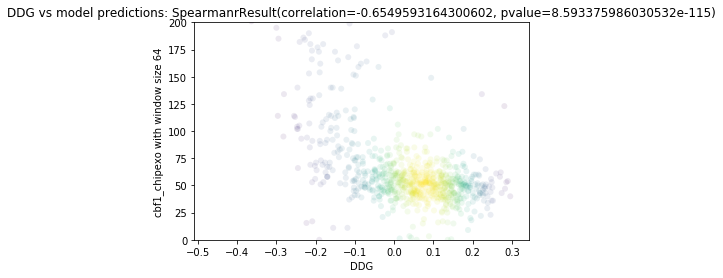

cbf1_pbexo


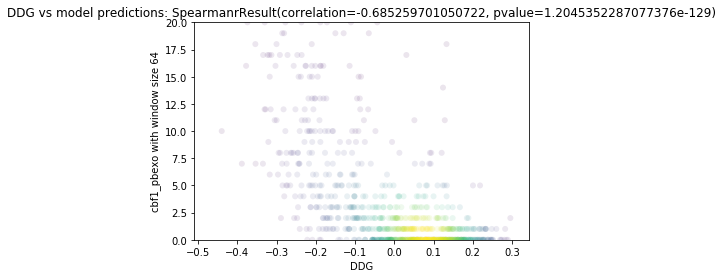

pho4_pbexo


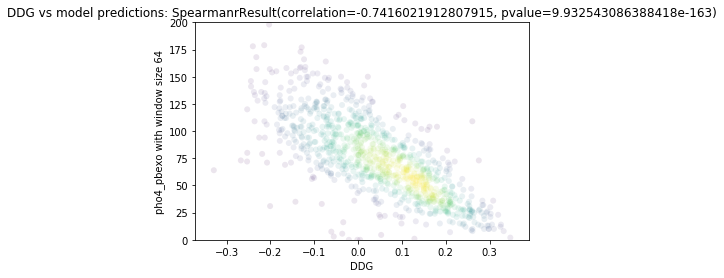

In [13]:
window = 64
print(window)
start = int((seq_len/2)-(window/2))
end = int((seq_len/2)+(window/2))
dataDict = {} # tf then flank then (ddG, counts)
for key in tfToBigWigs.keys():
    print(key)
    dataDict[key] = {}
    if key == 'cbf1_pbexo':
        ddGDict = flankToCbf1Ddg
        lim = 20
    elif key == 'cbf1_chipexo':
        ddGDict = flankToCbf1Ddg
        lim = 200
    else:
        ddGDict = flankToPho4Ddg
        lim = 200
    xvals = []
    yvals = []
    for flank in flankToCoord.keys():
        counts = np.sum(posFootprint[key][flank][start:end]+ \
                        negFootprint[key][flank][start:end])
        dataDict[key][flank] = (ddGDict[flank], counts)
        xvals.append(ddGDict[flank])
        yvals.append(counts)
    xy = np.vstack([xvals,yvals])
    z = gaussian_kde(xy)(xy)
    smallFont = {'size' : 10}
    plt.rc('font', **smallFont)
    fig, ax = plt.subplots()
    ax.scatter(xvals, yvals, c=z, edgecolor='', alpha=0.1)
    plt.xlabel("DDG")
    plt.ylabel(key+" with window size "+str(window))
    plt.ylim((0,lim))
    plt.title("DDG vs model predictions: "+str(spearmanr(xvals, yvals)))
    plt.show()

In [14]:
import os
import math
import json
import codecs
import numpy as np
from numpy import log, exp
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
from scipy.optimize import minimize
from scipy.stats import spearmanr, pearsonr, gaussian_kde

In [15]:
def sigmoid(x):
    return 1 / (1 + exp(-x))

def logit(p):
    return log(p) - log(1 - p)

In [16]:
class CalibratorFactory(object):
    def __call__(self, valid_preacts, valid_labels):
        raise NotImplementedError()

class SigmoidFit(CalibratorFactory):
    def __init__(self, verbose=True):
        self.verbose = verbose

    def __call__(self, valid_preacts, valid_labels):
        def loss_func(x):
            new_preacts = (x[0]*sigmoid(-valid_labels+x[1]))+x[2]
            return mean_squared_error(new_preacts, valid_preacts)

        x0 = np.array([1.0, 0.0, 0.0])
        res = minimize(loss_func, x0, method='BFGS', options={'gtol': 1e-9, 'disp': True, 'maxiter': 1000})
        print("multiplier: ",res.x[0],", in sigmoid bias: ",res.x[1],", out of sigmoid bias: ",res.x[2])

        def calibration_func(label):
            return (res.x[0]*sigmoid(-label+res.x[1]))+res.x[2]

        def inv_func(preact):
            return -logit((preact-res.x[2])/res.x[0])+res.x[1]

        return calibration_func, inv_func

In [17]:
%matplotlib inline

def plotCorrs(key, xvals, yvals, xlabel, ylabel):
    if key == 'cbf1_pbexo':
        lim = 20
    elif key == 'cbf1_chipexo' or key == 'pho4_pbexo':
        lim = 200
    else:
        lim = None
    xy = np.vstack([xvals,yvals])
    z = gaussian_kde(xy)(xy)
    smallFont = {'size' : 10}
    plt.rc('font', **smallFont)
    fig, ax = plt.subplots()
    ax.scatter(xvals, yvals, c=z, edgecolor='', alpha=0.1)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if "counts" in ylabel and lim != None:
        plt.ylim((0,lim))
    plt.title("correlation: "+str(pearsonr(xvals, yvals)))
    plt.show()

In [24]:
validKeys = np.random.choice(list(flankToCoord.keys()),250, replace=False)

cbf1_chipexo
         Current function value: 37892.547577
         Iterations: 128
         Function evaluations: 1277
         Gradient evaluations: 253
multiplier:  69138.04595920627 , in sigmoid bias:  -4.213996802617096 , out of sigmoid bias:  -884.8903963028563


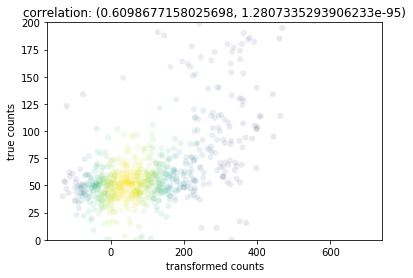

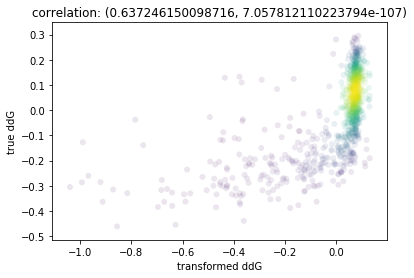

cbf1_pbexo
         Current function value: 41.451802
         Iterations: 268
         Function evaluations: 1946
         Gradient evaluations: 389
multiplier:  17624.506083468754 , in sigmoid bias:  -6.136871641478063 , out of sigmoid bias:  -34.4618180365031


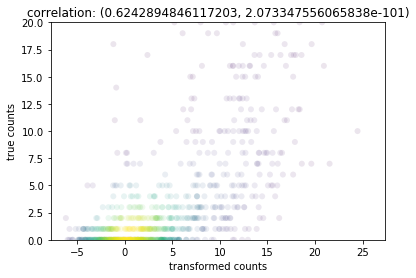

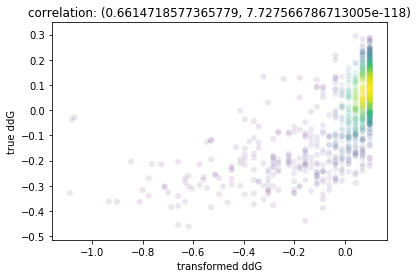

pho4_pbexo
         Current function value: 590.375828
         Iterations: 178
         Function evaluations: 1776
         Gradient evaluations: 353
multiplier:  1858.3780027327082 , in sigmoid bias:  1.8665579891965505 , out of sigmoid bias:  -1523.3568636391365


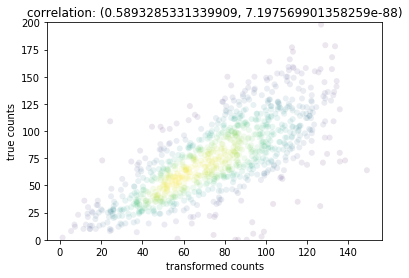

/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in log


In [25]:
for key in dataDict.keys():
    print(key)
    validDdG = []
    validCounts = []
    for flank in validKeys:
        validDdG.append(dataDict[key][flank][0])
        validCounts.append(dataDict[key][flank][1])
    validDdG = np.array(validDdG)
    validCounts = np.array(validCounts)
    preacts = []
    labels = []
    for flank in flankToCoord.keys():
        preacts.append(dataDict[key][flank][1])
        labels.append(dataDict[key][flank][0])
    preacts = np.array(preacts)
    labels = np.array(labels)
    sf = SigmoidFit()
    calibration_func, inv_func = sf(validCounts, validDdG)
    calibrated_preacts = calibration_func(labels)
    plotCorrs(key, calibrated_preacts, preacts, "transformed counts", "true counts")
    calibrated_labels = inv_func(preacts)
    if np.isnan(calibrated_labels).any():
        continue
    plotCorrs(key, calibrated_labels, labels, "transformed ddG", "true ddG")

cbf1_chipexo
         Current function value: 0.399577
         Iterations: 424
         Function evaluations: 2831
         Gradient evaluations: 566
multiplier:  5186.4170956431335 , in sigmoid bias:  -7.020411955732933 , out of sigmoid bias:  -0.3610447882636172


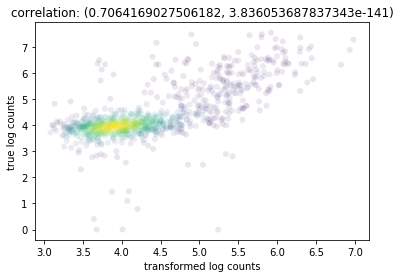

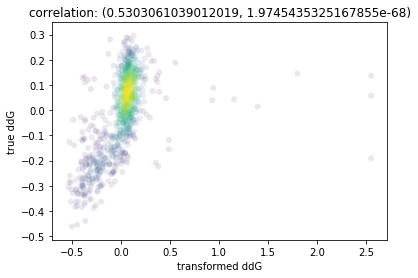

cbf1_pbexo
         Current function value: 0.473793
         Iterations: 502
         Function evaluations: 3416
         Gradient evaluations: 683
multiplier:  5439.79192884946 , in sigmoid bias:  -6.921383904570171 , out of sigmoid bias:  -4.537294793851977


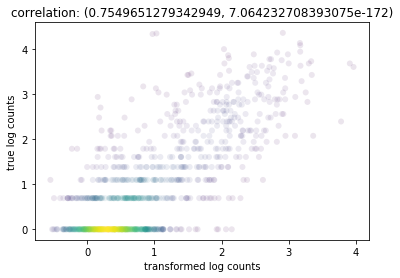

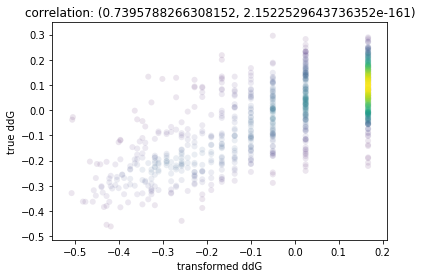

pho4_pbexo
         Current function value: 0.205675
         Iterations: 293
         Function evaluations: 2362
         Gradient evaluations: 470
multiplier:  541.2386918406609 , in sigmoid bias:  5.041538364444057 , out of sigmoid bias:  -533.403813350848


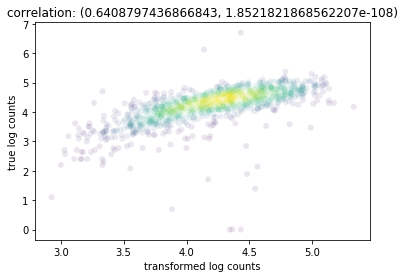

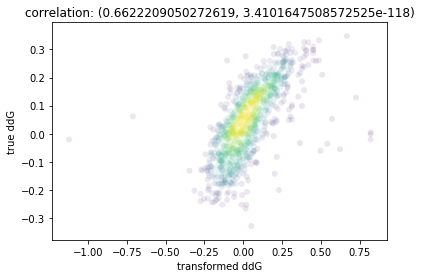

In [26]:
for key in dataDict.keys():
    print(key)
    validDdG = []
    validCounts = []
    for flank in validKeys:
        validDdG.append(dataDict[key][flank][0])
        validCounts.append(log(dataDict[key][flank][1]+1))
    validDdG = np.array(validDdG)
    validCounts = np.array(validCounts)
    preacts = []
    labels = []
    for flank in flankToCoord.keys():
        preacts.append(log(dataDict[key][flank][1]+1))
        labels.append(dataDict[key][flank][0])
    preacts = np.array(preacts)
    labels = np.array(labels)
    sf = SigmoidFit()
    calibration_func, inv_func = sf(validCounts, validDdG)
    calibrated_preacts = calibration_func(labels)
    plotCorrs("key", calibrated_preacts, preacts, "transformed log counts", "true log counts")
    calibrated_labels = inv_func(preacts)
    if np.isnan(calibrated_labels).any():
        continue
    plotCorrs("key", calibrated_labels, labels, "transformed ddG", "true ddG")